-----------------------------------------

# 1. Loading in data

## 1.1 Loading in Data and giving main variables and dataframes their names

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib as mp
# import gaia_tools as gt
import scipy
from scipy.ndimage import gaussian_filter
import astropy.units as u
from astropy.coordinates import SkyCoord
import math

1.1.1 Simulation data

In [169]:
# reading in simulation data about the LMC cdm wake
stars = np.load('C:/Users/dnurm/Desktop/Uni_files/Thesis/.venv/Data/star_particles_pos_5e8.npy') # home PC
#stars = np.load('C:/Data/Praktika_data/star_particles_pos_5e8.npy') #laptop path
starsdf = pd.DataFrame(stars)
starsdf = starsdf.rename(columns={0:"x", 1:"y", 2:"z"})

# to remove outliers in the z axis with np.where, I first need to convert the column to a numeric type with pd.to_numeric.
# z axis is chosen specifically because, if the data is plotted in the x-z axis, the relevant data is clearly bound between -20 and 20 kpc.
# This 

starsdf["z"] = pd.to_numeric(starsdf["z"], errors="coerce")
starsdf['z'] = np.where((starsdf['z'] > 20) | (starsdf['z'] < -20), np.nan, starsdf['z'])
starsdf = starsdf.dropna(subset=["z"])

x_s = starsdf['x']
y_s = starsdf['y']
z_s = starsdf['z']

large_cloud = np.array([x_s, y_s, z_s])

bins = (35, 35)

In [170]:
file = 'C:/Users/dnurm/Desktop/Uni_files/Thesis/.venv/Data/trajlmc.txt'
#file = 'C:/Data/Praktika_data/trajlmc.txt'
orbit = pd.read_csv(file, delimiter=' ')

1.1.2 Mock wake generator

In [171]:
# Mock wake generator
def generate_mock_wake(
    
    N_total=300_000,
    box_half_size=300.0,                 # kpc; box is [-L, L]^3
    f_overdense=0.25,                    # fraction of particles in wake component
    mu=(-30.0, 5.0, 0.0),                # kpc; wake center (x0, y0, z0)
    sigma_major=100.0,                    # kpc; wake length-scale along major axis
    sigma_minor=50.0,                    # kpc; width in the orthogonal in-plane axis
    sigma_z=8.0,                         # kpc; thickness
    theta_deg=0.0,                       # rotation of wake in XY plane (deg)
    rng_seed=7
):
    """
    Return a structured ndarray with fields: x,y,z,component (1=wake, 0=bg).
    """
    rng = np.random.default_rng(rng_seed)
    N_over = int(N_total * f_overdense)
    N_bg   = N_total - N_over
    mu = np.asarray(mu, dtype=float)

    # Rotation in the XY plane
    theta = np.deg2rad(theta_deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s],
                  [s,  c]])

    # Covariance in XY for the anisotropic Gaussian
    Lambda_xy = np.diag([sigma_major**2, sigma_minor**2])
    Sigma_xy  = R @ Lambda_xy @ R.T

    # Wake samples
    xy_over = rng.multivariate_normal(mean=mu[:2], cov=Sigma_xy, size=N_over)
    z_over  = rng.normal(loc=mu[2], scale=sigma_z, size=N_over)

    # Clip to keep inside box
    xy_over[:, 0] = np.clip(xy_over[:, 0], -box_half_size, box_half_size)
    xy_over[:, 1] = np.clip(xy_over[:, 1], -box_half_size, box_half_size)
    z_over        = np.clip(z_over,        -box_half_size, box_half_size)

    # Uniform background
    x_bg = rng.uniform(-box_half_size, box_half_size, size=N_bg)
    y_bg = rng.uniform(-box_half_size, box_half_size, size=N_bg)
    z_bg = rng.uniform(-box_half_size, box_half_size, size=N_bg)

    # Concatenate positions
    x = np.concatenate([xy_over[:, 0], x_bg])
    y = np.concatenate([xy_over[:, 1], y_bg])
    z = np.concatenate([z_over,        z_bg])

    # Pack catalog
    comp = np.concatenate([np.ones(N_over, dtype=np.int8),
                           np.zeros(N_bg, dtype=np.int8)])  # 1=wake, 0=bg
    

    cat = np.zeros(N_total, dtype=[('x','f4'),('y','f4'),('z','f4'),('component','i1')])
    
    cat['x'], cat['y'], cat['z']   = x, y, z
    cat['component'] = comp
    return cat


1.1.3 Generating mock wake data based on parameters from the cell above (Section 1.1.2)

In [172]:
result = generate_mock_wake()

df = pd.DataFrame(result)
df
coords = df[['x', 'y', 'z']].values

x_sim = result['x']
y_sim = result['y']
z_sim = result['z']

sim = np.array([x_sim, y_sim, z_sim])

## 1.2 Defining different fucntions used in this notebook

In [ ]:
#-----------------------------------------------------------------------------------------------------------------
# 3D rotation matrixes
def rx(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[1, 0, 0],
                     [0, c,-s],
                     [0, s, c]])
def ry(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[ c, 0, s],
                     [ 0, 1, 0],
                     [-s, 0, c]])
def rz(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c,-s, 0],
                     [s, c, 0],
                     [0, 0, 1]])

def rotate(rot_mat, vec):
    return rot_mat @ vec

#-----------------------------------------------------------------------------------------------------------------

extent = [-60, 60, -60, 60]
def plot_OD_gaussian(x, y, bins, sigma, title, xaxis, yaxis): # x coord, y coord, nr of bins, extent of plot, sigma for gaussian filter, title of plot, x axis title, y axis title
    fig,ax = plt.subplots()
    
    def overdensity(x, y, bins):  # generating the overdensity map
        pre_OD, xedges, yedges = np.histogram2d(x, y, bins)
        OD = (pre_OD / np.mean(pre_OD)-1)
        return OD, xedges, yedges
    
    OD, xedges, yedges = overdensity(x, y, bins) # calling out the function
    im = ax.imshow(OD.T, origin='lower', cmap = "seismic")
    c = plt.colorbar(im, ax=ax)
    plt.title(str(title))
    plt.xlabel(str(xaxis))
    plt.ylabel(str(yaxis))
    c.set_label('difference from average star density', rotation=270, labelpad=20)
    hist_smoothed = gaussian_filter(OD.T, sigma=sigma)
    image = plt.imshow(hist_smoothed, origin='lower', extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="seismic")
    return image

#-----------------------------------------------------------------------------------------------------------------
def angle_between(v1, v2):
    v1_v2 = np.dot(v1, v2)
    mag_v1 = np.linalg.norm(v1)
    mag_v2 = np.linalg.norm(v2)
    angle_Z = np.arccos(v1_v2 / (mag_v1 * mag_v2))
    return np.degrees(angle_Z)

#-----------------------------------------------------------------------------------------------------------------
# This function finds the angles of rotation around the z and y axes 
def angle_finder(LMC_velocity_components): # x, y, and z components of the LMC velocity vector
    vel_vec_x =(42, 0, 0) # random vector pointing towards x axis. x = 42 because it is the answer to the ultimate question of life, the universe and everything.
    v_LMC = LMC_velocity_components
    Rz = angle_between([vel_vec_x[0], vel_vec_x[1]], [v_LMC[0], v_LMC[1]]) # angle between the two vectors in 2D
    
        # -------------------------------------------------------------------------#
    if (((v_LMC[0] < 0) & (v_LMC[1] <= 0 )) | ((v_LMC[0] > 0) & (v_LMC[1] <= 0))):
        Rz = -Rz
    else:
        Rz = Rz
        # -------------------------------------------------------------------------#  
           
    rotated_2D = rotate(rz(np.radians(Rz)), vel_vec_x) # rotation matrix around z axis

    Ry = angle_between(rotated_2D, v_LMC) # angle between the two vectors in 3D
        
        # -------------------------------------------------------------------------#
    if (((v_LMC[0] < 0) & (v_LMC[2] >= 0 )) | ((v_LMC[0] > 0) & (v_LMC[2] <= 0 ))): # to determine the direction of rotation
        Ry = -Ry
    else:
        Ry = Ry
        # -------------------------------------------------------------------------#
    print(f"Rz = {Rz}, Ry = {Ry}")
    return Rz, Ry


----------------------------------------------------------------------------------------------------------------------------------------------

---

## 1.3 Testing out the rotations to see if my math and code works as intended

In this section I will do a simple 3D rotation to check whether I can rotate a vector in 3D in such a way that it will become collinear with another vector.

In [ ]:
line111 = np.array([10, 0, 0]) # a line along the x axis

R1 = rz(math.radians(135)) @ ry(math.radians(-35.26))
line12 = R1 @ line111


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Test Vector rotations')

axs[0,0].quiver(
    0, 0,
    -1, 1,
    angles='xy', scale_units='xy', scale=1,
    pivot='tail', color='r'
)
axs[0,0].set_xlim(-5, 5)
axs[0,0].set_ylim(-5, 5)
axs[0,0].plot(line12[0], line12[1], color='black', linestyle='dashed', label='xz axis')



axs[0,1].quiver(
    0, 0,
    -1, 1,
    angles='xy', scale_units='xy', scale=1,
    pivot='tail', color='r'
)
axs[0,1].set_xlim(-5, 5)
axs[0,1].set_ylim(-5, 5)
axs[0,1].plot(line12[0], line12[2], color='black', linestyle='dashed', label='xz axis')

# axs[0, 1].plot(orbit['x'], orbit['z'])
# axs[0,1].set_xlim(-100, 100)
# axs[0,1].set_ylim(-100, 100)
# axs[0,1].quiver(
#     origin[0], origin[2],
#     Ux, Uz,
#     angles='xy', scale_units='xy', scale=1,
#     pivot='tail', color='r'
# )
# axs[0, 1].scatter(origin[0], origin[2], color='g', label='Current position')
# axs[0, 1].scatter(0, 0, color='m', label='Plot Origin')
# axs[0, 1].plot(line2[0], line2[2], color='black', linestyle='dashed', label='xz axis')
# axs[0, 1].legend(['Orbit path', 'Velocity vector', 'LMC Current position', 'Plot Origin', 'xz axis'])


# axs[1, 0].plot(orbit['y'], orbit['z'])
# axs[1,0].set_xlim(-100, 100)
# axs[1,0].set_ylim(-100, 100)
# axs[1, 0].quiver(
#     origin[1], origin[2],
#     Uy, Uz,
#     angles='xy', scale_units='xy', scale=1,
#     pivot='tail', color='r'
# )
# axs[1, 0].scatter(origin[1], origin[2], color='g', label='Current position')
# axs[1, 0].scatter(0, 0, color='m', label='Plot Origin')
# axs[1, 0].plot(line2[1], line2[2], color='black', linestyle='dashed', label='yz axis')
# axs[1, 0].legend(['Orbit path', 'Velocity vector', 'LMC Current position', 'Plot Origin', 'yz axis'])


# for ax in axs.flat:
#     ax.set(xlabel='kpc', ylabel='kpc')

# 2. Rotating simulation data

2.1 Testing out my gaussian plot function on simulation data

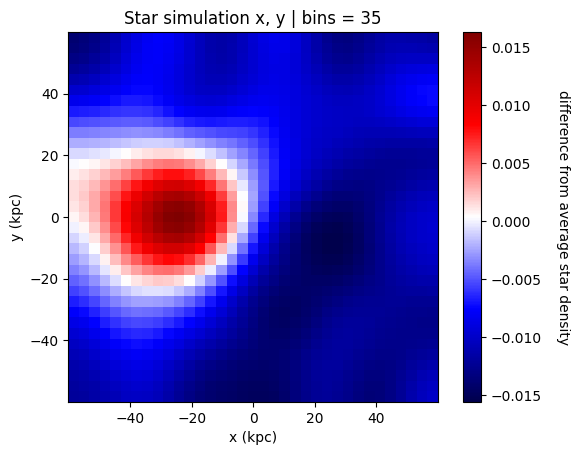

In [174]:
plot_OD_gaussian(x_s, y_s, (35, 35), 3, 'Star simulation x, y | bins = 35', 'x (kpc)', 'y (kpc)')

2.2 Rotating the mock wake data

In [175]:
sim_rot = rotate(rz(np.pi/2), sim)

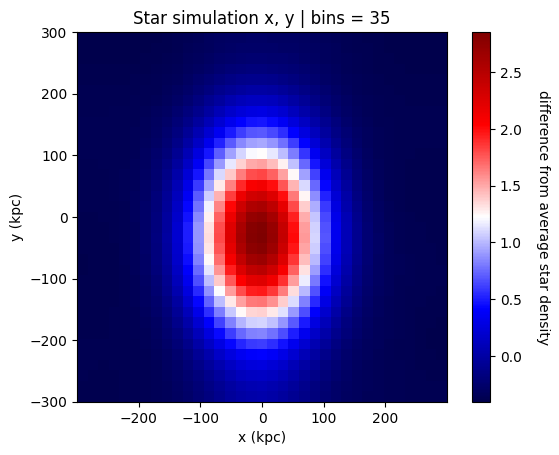

In [176]:
plot_OD_gaussian(sim_rot[0], sim_rot[1], (35, 35), 3, 'Star simulation x, y | bins = 35', 'x (kpc)', 'y (kpc)')

2.3 Velocity and position of the LMC

In [203]:
#the current day position of the LMC is at row index 400. 
today_orbit = orbit.iloc[400]

#Definig the current day velocity and position of the LMC
today = np.array([today_orbit['Vx'], today_orbit['Vy'], today_orbit['Vz']])
origin = np.array([today_orbit['x'], today_orbit['y'], today_orbit['z']])


# This helps to regulate the vecotr length of the LMC velocity arrow
vx, vy, vz = today_orbit['Vx'], today_orbit['Vy'], today_orbit['Vz']
factor = 150  # how long you want the arrow in kpc-units space
length = (vx**2 + vy**2 + vz**2)**0.5
Ux, Uy, Uz = vx/length * factor, vy/length * factor, vz/length * factor
speed = np.array([Ux, Uy, Uz]) 


In [180]:
Rz, Ry = angle_finder(today)

Rz = -106.60046723806266, Ry = -42.703323366316084


2.4 Plotting the LMC position, orbit, and velcity vector alongside a representation of the simulated data velocity vector. 

2.4.1 Generate a test line which represents a line along the x axis. This line will be rotated to match the current day velocity vector of the LMC

In [ ]:
# line along the x axis
line1 = np.array([np.linspace(-300, 300, 3), np.zeros(3), np.zeros(3)])


In [204]:
#Rotation matrix

R = (rz(math.radians(Rz)) @ ry(math.radians(Ry)))
line2 = R @ line1

2.4.2 Plotting the rotation

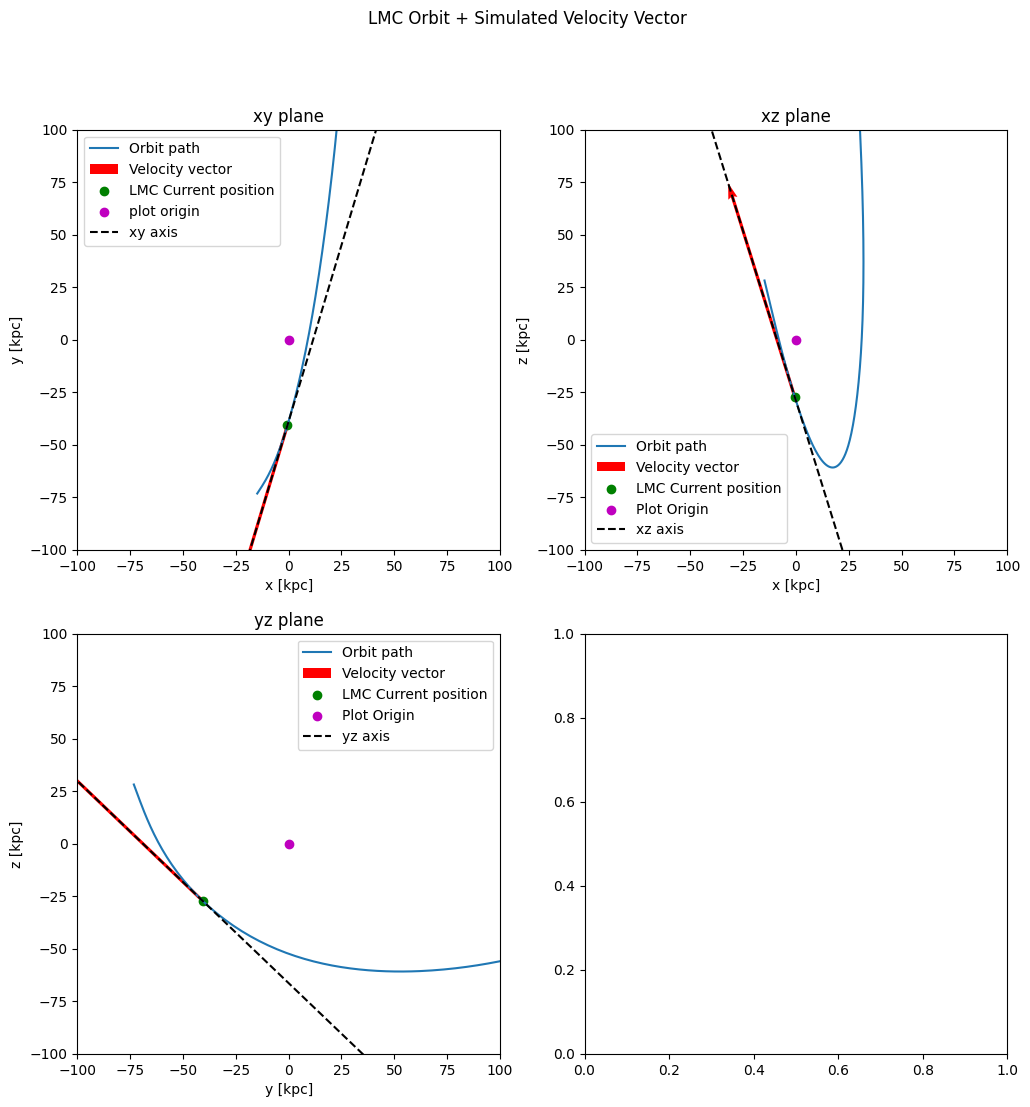

In [201]:
# Visualizing velocity vectors on the orbit to see what direction I need to rotate the simulations
#xy, xz, yz axis refers to the x axis line as seen on the respective 2D views. xy axis means the x axis line as seen depicted on the xy plot, etc. 

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('LMC Orbit + Simulated Velocity Vector')

axs[0, 0].plot(orbit['x'], orbit['y'])
#axs[0, 0].quiver(origin[0], origin[1], today[0] * 30000000, today[1] * 30000000, angles='xy', scale_units='xy', color='r',  width=0.009)
axs[0,0].quiver(
    origin[0], origin[1],
    Ux, Uy,
    angles='xy', scale_units='xy', scale=0.001,
    pivot='tail', color='r'
)
axs[0,0].set_title('xy plane')
axs[0,0].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')
axs[0,0].set_xlim(-100, 100)
axs[0,0].set_ylim(-100, 100)
axs[0, 0].scatter(origin[0], origin[1], color='g', label='Current position')
axs[0, 0].scatter(0, 0, color='m', label='Plot Origin')
axs[0, 0].plot(line2[0]+origin[0], line2[1]+origin[1], color='black', linestyle='dashed', label='xy axis')
axs[0,0].legend(['Orbit path', 'Velocity vector', 'LMC Current position', 'plot origin', 'xy axis'])



axs[0, 1].plot(orbit['x'], orbit['z'])
axs[0,1].set_xlim(-100, 100)
axs[0,1].set_ylim(-100, 100)
axs[0,1].quiver(
    origin[0], origin[2],
    Ux, Uz,
    angles='xy', scale_units='xy', scale=1,
    pivot='tail', color='r'
)
axs[0,1].set_title('xz plane')
axs[0,1].set_xlabel('x [kpc]')
axs[0,1].set_ylabel('z [kpc]')
axs[0, 1].scatter(origin[0], origin[2], color='g', label='Current position')
axs[0, 1].scatter(0, 0, color='m', label='Plot Origin')
axs[0, 1].plot(line2[0]+origin[0], line2[2]+origin[2], color='black', linestyle='dashed', label='xz axis')
axs[0, 1].legend(['Orbit path', 'Velocity vector', 'LMC Current position', 'Plot Origin', 'xz axis'])


axs[1, 0].plot(orbit['y'], orbit['z'])
axs[1,0].set_xlim(-100, 100)
axs[1,0].set_ylim(-100, 100)
axs[1, 0].quiver(
    origin[1], origin[2],
    Uy, Uz,
    angles='xy', scale_units='xy', scale=1,
    pivot='tail', color='r'
)
axs[1,0].set_title('yz plane')
axs[1,0].set_xlabel('y [kpc]')
axs[1,0].set_ylabel('z [kpc]')
axs[1, 0].scatter(origin[1], origin[2], color='g', label='Current position')
axs[1, 0].scatter(0, 0, color='m', label='Plot Origin')
axs[1, 0].plot(line2[1]+origin[1], line2[2]+origin[2], color='black', linestyle='dashed', label='yz axis')
axs[1, 0].legend(['Orbit path', 'Velocity vector', 'LMC Current position', 'Plot Origin', 'yz axis'])


In [188]:
a = np.array([1, 0, 0])

f =rz(math.radians(135)) @ a

In [189]:
LMC_sim = np.array([x_sim, y_sim, z_sim])

LMC_sim_rot = R @ LMC_sim


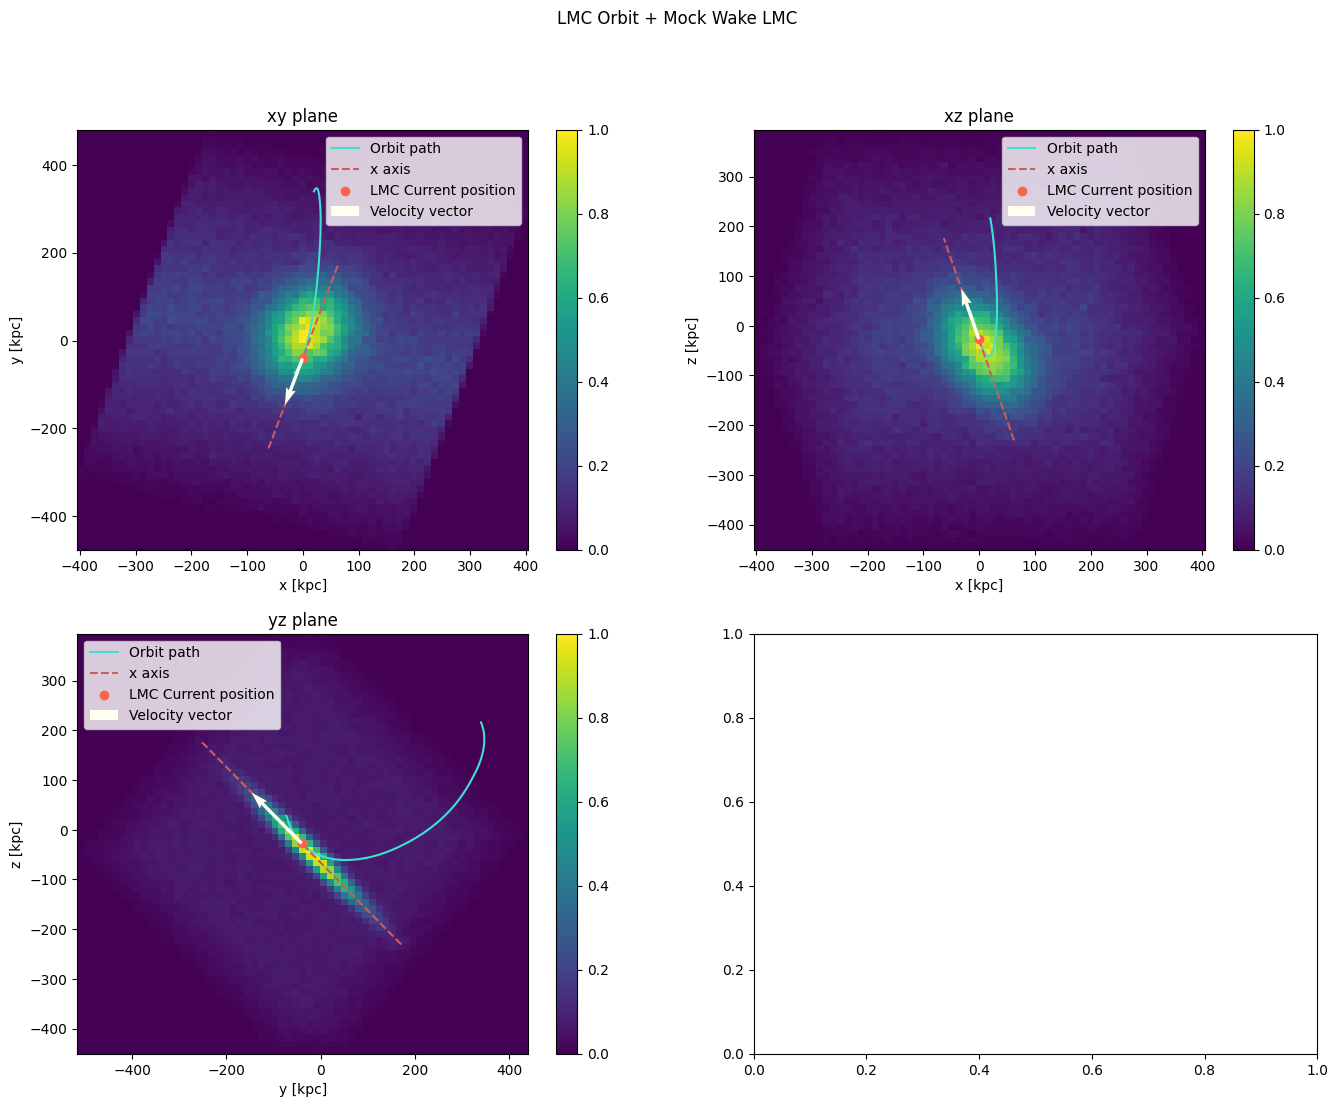

In [224]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('LMC Orbit + Mock Wake LMC')
bins = (65, 65)
color_orbit = 'turquoise'
color_axis = 'indianred'
color_cmap = 'viridis'
color_velocity = 'ivory'
color_current_pos = 'tomato'


axs[0, 0].hist2d(LMC_sim_rot[0] + origin[0], LMC_sim_rot[1] + origin[0], bins = bins, cmap = color_cmap, zorder = 1)
axs[0, 0].plot(orbit['x'], orbit['y'],  color = color_orbit, zorder = 2)
axs[0, 0].plot(line2[0]+origin[0], line2[1]+origin[1], color=color_axis, linestyle='dashed', label='xy axis', zorder = 3)
axs[0, 0].scatter(origin[0], origin[1], color=color_current_pos, label='Current position', zorder = 4)
axs[0,0].quiver(
    origin[0], origin[1],
    Ux, Uy,
    angles='xy', scale_units='xy', scale=1,
    pivot='tail', color=color_velocity, zorder=5
)
cbar = plt.colorbar(mappable=mp.cm.ScalarMappable(cmap=color_cmap), ax=axs[0,0])
axs[0,0].set_title('xy plane')
axs[0,0].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')

axs[0,0].legend(['Orbit path', 'x axis', 'LMC Current position', 'Velocity vector'])



axs[0, 1].hist2d(LMC_sim_rot[0] + origin[0], LMC_sim_rot[2] + origin[2], bins = bins, cmap = color_cmap, zorder = 1)
axs[0, 1].plot(orbit['x'], orbit['z'], color = color_orbit, zorder = 2)
axs[0, 1].plot(line2[0]+origin[0], line2[2]+origin[2], color= color_axis, linestyle='dashed', label='xz axis', zorder = 3)
axs[0, 1].scatter(origin[0], origin[2], color= color_current_pos, label='Current position', zorder = 4)
axs[0,1].quiver(
    origin[0], origin[2],
    Ux, Uz,
    angles='xy', scale_units='xy', scale=1,
    pivot='tail', color= color_velocity, zorder = 5
)

cbar = plt.colorbar(mappable=mp.cm.ScalarMappable(cmap=color_cmap), ax=axs[0,1])
axs[0,1].set_title('xz plane')
axs[0,1].set_xlabel('x [kpc]')
axs[0,1].set_ylabel('z [kpc]')


axs[0, 1].legend(['Orbit path', 'x axis', 'LMC Current position', 'Velocity vector'])

axs[1, 0].hist2d(LMC_sim_rot[1] + origin[1], LMC_sim_rot[2] + origin[2], bins = bins, cmap = color_cmap, zorder = 1)
axs[1, 0].plot(orbit['y'], orbit['z'], color = color_orbit, zorder = 2)
axs[1, 0].plot(line2[1]+origin[1], line2[2]+origin[2], color = color_axis, linestyle='dashed', label='yz axis', zorder = 3)
axs[1, 0].scatter(origin[1], origin[2], color= color_current_pos, label='LMC Current position', zorder = 4)
axs[1, 0].quiver(
    origin[1], origin[2],
    Uy, Uz,
    angles='xy', scale_units='xy', scale=1,
    pivot='tail', color = color_velocity, zorder = 5
)
cbar = plt.colorbar(mappable=mp.cm.ScalarMappable(cmap=color_cmap), ax=axs[1,0])
axs[1,0].set_title('yz plane')
axs[1,0].set_xlabel('y [kpc]')
axs[1,0].set_ylabel('z [kpc]')

axs[1, 0].legend(['Orbit path', 'x axis', 'LMC Current position', 'Velocity vector'])


In [194]:
lmc_coord_rot = SkyCoord(LMC_sim_rot[0], LMC_sim_rot[1], LMC_sim_rot[2], unit='kpc', representation_type='cartesian')
LMC_gal_cent= lmc_coord_rot.galactocentric

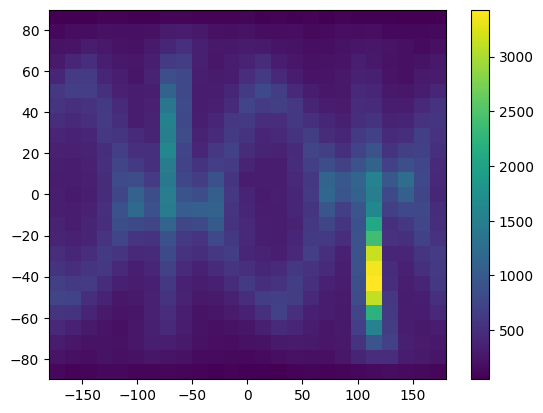

In [195]:
# mister owl lol
LMC_l = -LMC_gal_cent.galactic.l.wrap_at(180*u.deg).value
LMC_b = LMC_gal_cent.galactic.b.value
LMC_hist = plt.hist2d(LMC_l, LMC_b, (25, 25))
plt.colorbar()


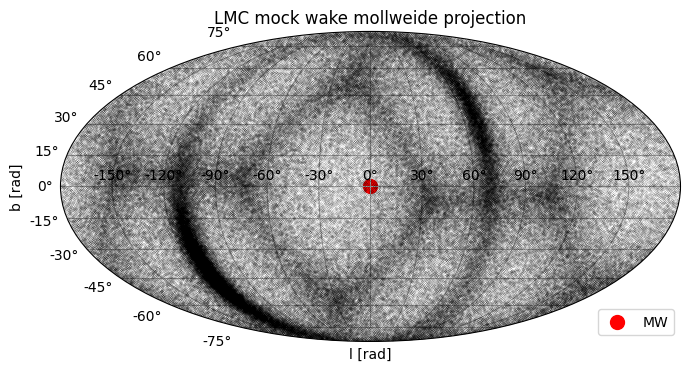

In [196]:
# 1 nanosecond after nuclear bomb explosion
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="mollweide")

ax.plot(LMC_gal_cent.galactic.l.wrap_at('180d').radian, 
        LMC_gal_cent.galactic.b.radian, 'k.', markersize=0.1)
ax.scatter(0, 0, c='r', s=100, label='MW', )# MW position
ax.set_xlabel('l [rad]')
ax.set_ylabel('b [rad]')
ax.set_title('LMC mock wake mollweide projection')
ax.legend( loc='lower right')
ax.grid(True)